In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import KMeans
import sys
sys.path.append('../') 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary functions
from src.loader import load_data
from src.clean import clean_data

# Load data
sql_query = '''
    
 SELECT * FROM xdr_data
 '''

df = load_data(sql_query)


In [2]:
# apply data cleaning function
df = clean_data(df)

In [3]:
# Updated feature names based on the actual column names
engagement_features = ['Total DL (Bytes)', 'Total UL (Bytes)']  # Assuming total data volume is the sum of these
experience_features = ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)']


In [4]:
# Calculate the Total Data Volume for each user
df['Total Data Volume (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']


In [5]:
# Scaling data
scaler = StandardScaler()
engagement_data = scaler.fit_transform(df[engagement_features])
experience_data = scaler.fit_transform(df[experience_features])

# Clustering for engagement
kmeans_engagement = KMeans(n_clusters=3, random_state=42).fit(engagement_data)
engagement_centroid = kmeans_engagement.cluster_centers_[np.argmin(kmeans_engagement.cluster_centers_.sum(axis=1))]

# Clustering for experience
kmeans_experience = KMeans(n_clusters=3, random_state=42).fit(experience_data)
experience_centroid = kmeans_experience.cluster_centers_[np.argmax(kmeans_experience.cluster_centers_.sum(axis=1))]


In [6]:
def calculate_distance_to_centroid(features, centroid):
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Calculate the distance from each point to the given centroid
    distances = euclidean_distances(scaled_features, [centroid])
    return distances.ravel()

# Calculate scores
df['Engagement Score'] = calculate_distance_to_centroid(df[engagement_features], engagement_centroid)
df['Experience Score'] = calculate_distance_to_centroid(df[experience_features], experience_centroid)


   MSISDN/Number  Engagement Score  Experience Score
0   3.366496e+10          0.991265          4.440119
1   3.368185e+10          2.360592          4.307096
2   3.376063e+10          0.801767          4.404756
3   3.375034e+10          2.006235          4.404756
4   3.369980e+10          0.962712          4.404756


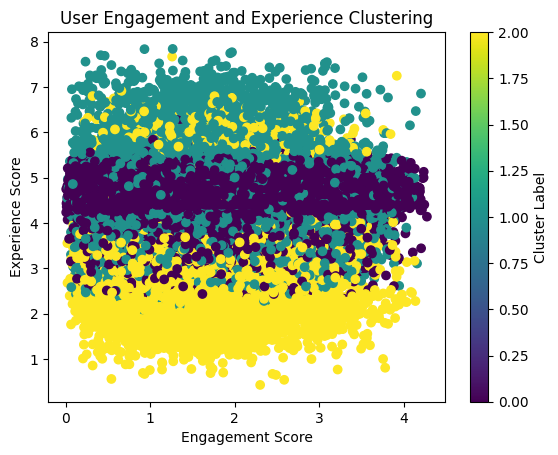

In [7]:
# Print the head of the DataFrame to see the top rows
print(df[['MSISDN/Number', 'Engagement Score', 'Experience Score']].head())

# Optionally, plot a scatter to visualize the distribution of scores
import matplotlib.pyplot as plt
plt.scatter(df['Engagement Score'], df['Experience Score'], c=kmeans_experience.labels_)
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.title('User Engagement and Experience Clustering')
plt.colorbar(label='Cluster Label')
plt.show()


### Task 5.2 - Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer 


In [8]:
# Calculate the satisfaction score
df['Satisfaction Score'] = (df['Engagement Score'] + df['Experience Score']) / 2


In [9]:
# Find the top 10 satisfied customers
top_10_satisfied_customers = df.sort_values(by='Satisfaction Score', ascending=True).head(10)


In [10]:
# Display the top 10 satisfied customers
print("Top 10 Satisfied Customers:")
print(top_10_satisfied_customers[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']])


Top 10 Satisfied Customers:
        MSISDN/Number  Engagement Score  Experience Score  Satisfaction Score
140999   3.365886e+10          0.539738          0.557061            0.548399
13583    3.366125e+10          0.317950          0.853556            0.585753
93932    3.376041e+10          0.203342          1.008174            0.605758
36588    3.362262e+10          0.247343          1.099899            0.673621
31909    3.366376e+10          0.432019          1.002214            0.717117
137538   3.366549e+10          0.407282          1.062029            0.734655
113719   3.376247e+10          0.377966          1.148989            0.763478
95204    3.369524e+10          0.213877          1.314855            0.764366
94089    3.366577e+10          0.419814          1.153037            0.786426
135527   3.366617e+10          0.708137          0.878818            0.793478


### Task 5.3 
- Build a regression model of your choice to predict the satisfaction score of a customer. 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming satisfaction, engagement, and experience scores are already calculated and added to df
# Define predictors and the target variable
X = df[['Engagement Score', 'Experience Score']]  # predictors
y = df['Satisfaction Score']  # target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [13]:
# Make predictions
y_pred = model.predict(X_test_scaled)
print(y_pred)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-Squared:", r2)


[3.69846082 2.80168664 3.62317156 ... 3.60660585 2.83587314 3.51996496]
Mean Squared Error: 5.456204661903088e-31
R-Squared: 1.0


## Task 5.4 
- Run a k-means (k=2) on the engagement & the experience score . 


In [14]:

# Select only the relevant features for clustering
features = df[['Engagement Score', 'Experience Score']]


In [15]:
# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [16]:
# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add the cluster labels to your DataFrame
df['Cluster'] = clusters


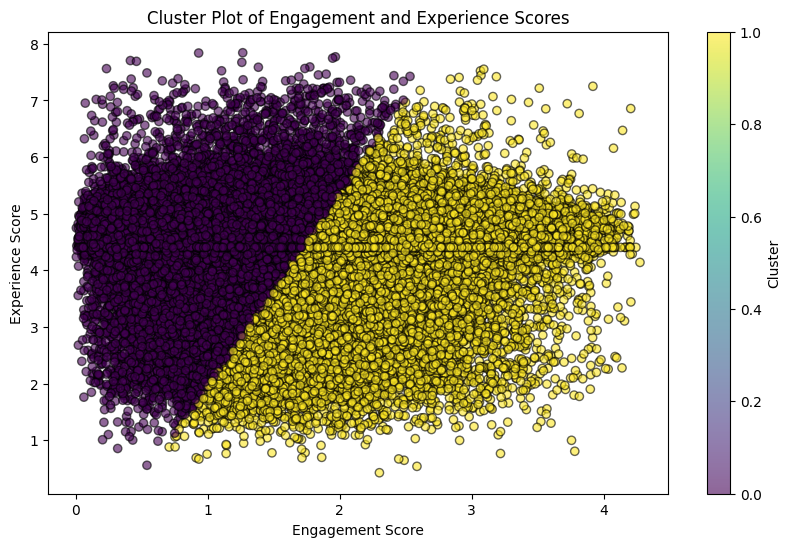

Cluster Centers (Engagement, Experience):
[[1.16061444 4.60769764]
 [2.33024882 4.36754861]]


In [17]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['Engagement Score'], df['Experience Score'], c=df['Cluster'], cmap='viridis', alpha=0.6, edgecolors='black')
plt.title('Cluster Plot of Engagement and Experience Scores')
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.colorbar(label='Cluster')
plt.show()

# Display cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers (Engagement, Experience):")
print(centers)


### Task 5.5 
- Aggregate the average satisfaction & experience score per cluster. 


In [18]:
# calculate the satisfaction score 
df['Satisfaction Score'] = (df['Engagement Score'] + df['Experience Score']) / 2


In [19]:
# Aggregate average scores per cluster
cluster_aggregates = df.groupby('Cluster').agg({
    'Satisfaction Score': 'mean',
    'Experience Score': 'mean'
}).reset_index()

# Renaming the columns for clarity
cluster_aggregates.rename(columns={
    'Satisfaction Score': 'Average Satisfaction Score',
    'Experience Score': 'Average Experience Score'
}, inplace=True)


In [20]:
# Print the aggregated scores per cluster
print(cluster_aggregates)


   Cluster  Average Satisfaction Score  Average Experience Score
0        0                    2.882668                  4.607380
1        1                    3.348295                  4.369396


/var/folders/xm/hbwsr__s2bnfkwhtlgztw7wm0000gn/T/ipykernel_3928/897520708.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Average Satisfaction Score', data=cluster_aggregates, palette='viridis')
/var/folders/xm/hbwsr__s2bnfkwhtlgztw7wm0000gn/T/ipykernel_3928/897520708.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Average Experience Score', data=cluster_aggregates, palette='viridis')


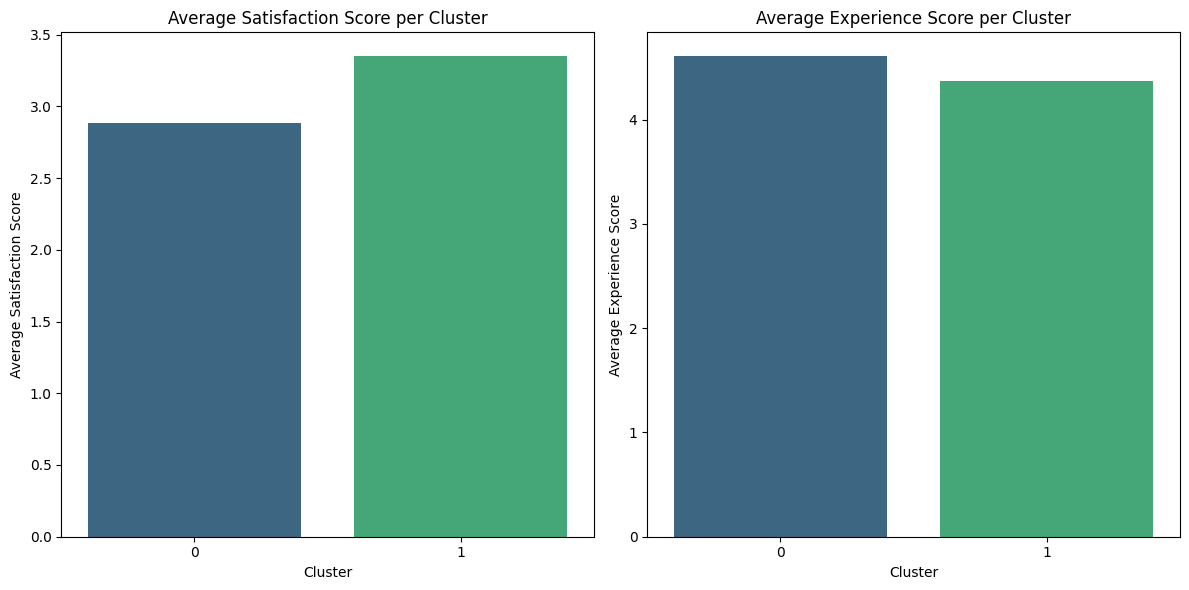

In [21]:

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting Average Satisfaction Score per Cluster
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.barplot(x='Cluster', y='Average Satisfaction Score', data=cluster_aggregates, palette='viridis')
plt.title('Average Satisfaction Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Satisfaction Score')

# Plotting Average Experience Score per Cluster
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.barplot(x='Cluster', y='Average Experience Score', data=cluster_aggregates, palette='viridis')
plt.title('Average Experience Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Experience Score')

plt.tight_layout()
plt.show()


### Task 5.6 
- Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select query output on the exported table. 

In [22]:
# Verify or calculate the satisfaction score again if necessary
df['Satisfaction Score'] = (df['Engagement Score'] + df['Experience Score']) / 2


In [30]:
from db_connection.db_connection import get_engine
from sqlalchemy import create_engine, text
# Get the database engine
engine = get_engine()

# Verify connection (optional)


In [31]:
# Create or connect to your PostgreSQL engine
engine = get_engine()

# Using 'text' to ensure the SQL command is executable
with engine.connect() as conn:
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS user_scores (
            user_id BIGINT PRIMARY KEY,
            engagement_score FLOAT,
            experience_score FLOAT,
            satisfaction_score FLOAT
        );
    """))
    print("Table checked/created in PostgreSQL database.")

Table checked/created in PostgreSQL database.


In [32]:
# Export the DataFrame to PostgreSQL using pandas 'to_sql' method
df.to_sql(name='user_scores', con=engine, if_exists='replace', index=False, method='multi')
print("Data exported successfully to PostgreSQL database!")


KeyboardInterrupt: 

In [ ]:
with engine.connect() as conn:
    result = conn.execute("SELECT * FROM user_scores LIMIT 5;")
    for row in result:
        print(row)


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib

# Assuming df is your DataFrame and the model is a simple linear regression
X = df[['Engagement Score', 'Experience Score']]  # Features
y = df['Satisfaction Score']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, '../model/linear_regression_model.pkl')


['../model/linear_regression_model.pkl']

In [35]:
import os

# Define the base directory where you want MLflow data to be stored
base_dir = '/Users/Air/10x-project/telecom_user_insights_10ac_week1'

# Create the MLflow directory if it doesn't exist
mlflow_dir = os.path.join(base_dir, 'mlruns')
os.makedirs(mlflow_dir, exist_ok=True)


In [36]:
import mlflow

# Set the MLflow tracking URI
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

# Verify the tracking URI setup
print("MLflow Tracking URI set to:", mlflow.get_tracking_uri())


MLflow Tracking URI set to: file:///Users/Air/10x-project/telecom_user_insights_10ac_week1/mlruns


In [38]:
mlflow.set_experiment("Satisfaction_Model_Tracking")

# Start an MLflow run
with mlflow.start_run():
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Train and log model
    model = LinearRegression()
    model.fit(X_train, y_train)
    mlflow.sklearn.log_model(model, "model")
    
    # Log metrics
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score", test_score)

    # End the run
    # mlflow.end_run()


/Users/Air/10x-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/Air/10x-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [39]:
import os
import mlflow
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the base directory and create the MLflow directory
base_dir = '/Users/Air/10x-project/telecom_user_insights_10ac_week1'
mlflow_dir = os.path.join(base_dir, 'mlruns')
os.makedirs(mlflow_dir, exist_ok=True)

# Set the MLflow tracking URI and set up the experiment
mlflow.set_tracking_uri(f"file://{mlflow_dir}")
print("MLflow Tracking URI set to:", mlflow.get_tracking_uri())


# Assuming df is your DataFrame and the model is a simple linear regression
X = df[['Engagement Score', 'Experience Score']]  # Features
y = df['Satisfaction Score']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_experiment("Satisfaction_Model_Tracking")

# Start an MLflow run
with mlflow.start_run():
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Train and log model
    model = LinearRegression()
    model.fit(X_train, y_train)
    mlflow.sklearn.log_model(model, "model")
    
    # Log metrics
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score", test_score)


MLflow Tracking URI set to: file:///Users/Air/10x-project/telecom_user_insights_10ac_week1/mlruns


/Users/Air/10x-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/Air/10x-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
